# Introduction

In this note, I'm analyzing the problem of predicting survival status of different kind of people in Titanic. This problem is a part of Kaggle challenges and is one of the problems begineers in Kaggle first attempts. The link to the problem is [https://www.kaggle.com/c/titanic](https://www.kaggle.com/c/titanic).

### Downloading the data

In [2]:
# Uncomment the below code during first use.
# It is assumed that kaggle is installed. Else install using pip.
# Otherwise, install from data from https://www.kaggle.com/c/titanic/data
# and keep extracted csv files under titanic_data
!mkdir titanic_data
!kaggle competitions download -c titanic -p titanic_data

mkdir: cannot create directory ‘titanic_data’: File exists
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


### Familiarization of data

In [3]:
# Import the essentials
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display

In [4]:
# Load data
df_train = pd.read_csv('titanic_data/train.csv')
df_test = pd.read_csv('titanic_data/test.csv')

In [5]:
print(df_train.keys())

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [6]:
# Look at the data
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# Describe (Descriptive statistics)
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Age values are missing!

In [8]:
print(df_train['Age'].unique())

[22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.  ]


In [9]:
print("No. of missing age rows: %d" % len(df_train.loc[df_train['Age'].isnull()]))

No. of missing age rows: 177


# Feature Filtering

In [10]:
df_train.shape

(891, 12)

There are 11 features such as passenger id, ticket class, age, etc. Not all of the features are relevant (e.g., passenger id and cabin are not relevant for predicting survival probability of a passenger). We need to find the relevant features. Let's use the likelihood of survival of a person given some information (i.e., a feature) about him or her.

That is, compute  $\text{Probability}(Survival|Class)$, $\text{Probability}(Survival|Sex)$, etc.

If the likelihoods are not equally likely across diffferent feature values (e.g., different classes or different sexes), that feature is relevant Otherwise not.

In [11]:
def featurewise_survival_rate(data,feature):
    v = df_train[feature].value_counts()    
    s = df_train.groupby([feature])['Survived'].sum()    
    m = df_train.groupby([feature])['Survived'].mean()
    p = v/df_train['Pclass'].count()
    sp = s/df_train['Survived'].sum()
    feature_df = pd.DataFrame({'Total': v, 'Survived': s,'Survival rate': m, 
                               'Total Proportion': p, 'Survived Proportion': sp})
    return feature_df

### Passenger class

In [12]:
class_df = featurewise_survival_rate(df_train,'Pclass')
display(class_df)

,Total,Survived,Survival rate,Total Proportion,Survived Proportion
Pclass,,,,,
1,216,136,0.629630,0.242424,0.397661
2,184,87,0.472826,0.206510,0.254386
3,491,119,0.242363,0.551066,0.347953


Looking at classwise survival percentage, we can see that it is different for each class. Especially, class 1 had a better survival probability.

### Sex

In [13]:
sex_df = featurewise_survival_rate(df_train,'Sex')
display(sex_df)

,Total,Survived,Survival rate,Total Proportion,Survived Proportion
female,314,233,0.742038,0.352413,0.681287
male,577,109,0.188908,0.647587,0.318713


From above tables, it is clear that among the total number of females, a majority (74.20 %) survived, but only (18.89 %) of males survived despite the fact that there were more males (64.76 %) on board the ship.

### Siblings

In [14]:
sib_df = featurewise_survival_rate(df_train,'SibSp')
display(sib_df)

,Total,Survived,Survival rate,Total Proportion,Survived Proportion
SibSp,,,,,
0,608,210,0.345395,0.682379,0.614035
1,209,112,0.535885,0.234568,0.327485
2,28,13,0.464286,0.031425,0.038012
3,16,4,0.250000,0.017957,0.011696
4,18,3,0.166667,0.020202,0.008772
5,5,0,0.000000,0.005612,0.000000
8,7,0,0.000000,0.007856,0.000000


People with 1 or 2 siblings seems to have had an advantage when compared to people without siblings. People with moer siblings are very few and the data may be insufficient to conclude. 


### Parents & Children

In [15]:
parch_df = featurewise_survival_rate(df_train,'Parch')
display(parch_df)

,Total,Survived,Survival rate,Total Proportion,Survived Proportion
Parch,,,,,
0,678,233,0.343658,0.760943,0.681287
1,118,65,0.550847,0.132435,0.190058
2,80,40,0.500000,0.089787,0.116959
3,5,3,0.600000,0.005612,0.008772
4,4,0,0.000000,0.004489,0.000000
5,5,1,0.200000,0.005612,0.002924
6,1,0,0.000000,0.001122,0.000000


People with parents or children count of 1, 2 and 3 have larger survival rate.

Among the remaining features, fare is already taken care by class. Cabin and embarked location may not have any effect on survival.

### Age

As observed before, age values are missing for some records. So, we need to either remove those missing records or estimate the age from some other information. Currently, we remove the missing records in the analysis.

(-3.559, 83.979, 0.0, 0.03731584388730938)

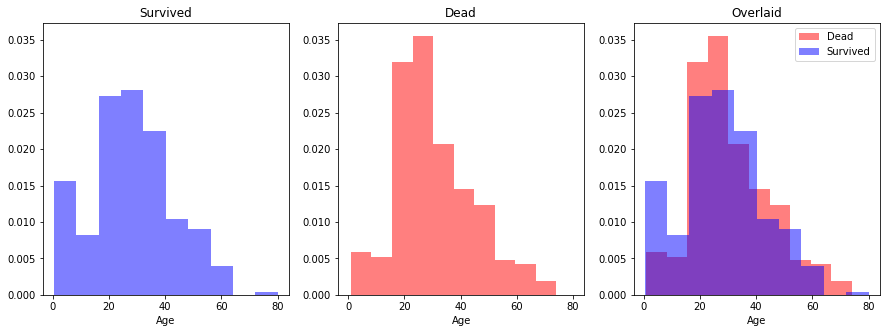

In [16]:
age_values_survived = df_train.loc[df_train['Survived']==1]['Age']
age_values_survived = age_values_survived.loc[age_values_survived.isnull()==False]
age_values_dead = df_train.loc[df_train['Survived']==0]['Age']
age_values_dead = age_values_dead.loc[age_values_dead.isnull()==False]
#age_values_all = pd.Series(np.hstack((age_values_dead,age_values_survived)))
age_values_all = df_train.loc[df_train['Age'].isnull()==False]['Age']
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.hist(age_values_survived,density=True,color='blue',alpha=0.5,label='Survived')
ax1.set_title('Survived')
ax1.set_xlabel('Age')
ax2.hist(age_values_dead,density=True,color='red',alpha=0.5,label='Dead')
ax2.set_title('Dead')
ax2.set_xlabel('Age')
ax3.hist(age_values_dead,density=True,alpha=0.5,color='red',label='Dead')
ax3.hist(age_values_survived,density=True,color='blue',alpha=0.5,label='Survived')
ax3.set_title('Overlaid')
ax3.set_xlabel('Age')
ax3.legend(loc='best')
lim = ax3.axis()
ax1.axis(lim)
ax2.axis(lim)

The above histograms show that among the survived, there were more children compared to older people than among the dead. We can conclude that children were more likely to survive than older people. So, age plays a role.

## Relevant Data

So, the relevant features are class, sex, age, sibsp & parch.

In [17]:
df_train1 = df_train[['Pclass','Sex','Age','SibSp','Parch','Survived']]
df_train1.head()

,Pclass,Sex,Age,SibSp,Parch,Survived
0,3,male,22.0,1,0,0
1,1,female,38.0,1,0,1
2,3,female,26.0,0,0,1
3,1,female,35.0,1,0,1
4,3,male,35.0,0,0,0


In [39]:
# Converting categorical feature to numerical one
df_train1_ = df_train1.assign(Sex=df_train1.Sex.astype('category').cat.codes.values)
df_train1_.head()

,Pclass,Sex,Age,SibSp,Parch,Survived
0,3,1,22.0,1,0,0
1,1,0,38.0,1,0,1
2,3,0,26.0,0,0,1
3,1,0,35.0,1,0,1
4,3,1,35.0,0,0,0


In [40]:
# Removing rows in which age is missing
df_train1_= df_train1.loc[df_train1['Age'].isnull() == False]
df_train1_.head()

,Pclass,Sex,Age,SibSp,Parch,Survived
0,3,1,22.0,1,0,0
1,1,0,38.0,1,0,1
2,3,0,26.0,0,0,1
3,1,0,35.0,1,0,1
4,3,1,35.0,0,0,0


# Nearest Neigbourhood

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [41]:
X_train,X_val,y_train,y_val = train_test_split(df_train1_.iloc[:,:-1],df_train1_.iloc[:,-1])

In [42]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [43]:
knn.score(X_val,y_val)

0.770949720670391

# Support Vector Classifier

In [44]:
from sklearn import svm

In [80]:
svc = svm.SVC(gamma=0.001,kernel='linear')
svc.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [81]:
svc.score(X_val,y_val)

0.7653631284916201